In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
import os
import shutil

import tensorflow as tf

from tensorflow.keras import layers

2024-05-06 15:24:11.972051: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-06 15:24:11.972176: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-06 15:24:12.252990: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
from IPython.display import clear_output as cls

In [10]:
!pip install ultralytics
!pip install roboflow
cls()

In [4]:
def plot_image(image):
    # Convert BGR image to RGB for plotting
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Plot the image
    plt.imshow(image)
    plt.axis('off')
    plt.show()

In [5]:
HEIGHT_SIZE = 300
WIDTH_SIZE = 300

def load_and_preprocess_image(image, label=None):
    # Resize the image to the desired size
    image = tf.image.resize(image, [HEIGHT_SIZE, WIDTH_SIZE])
    
    # Convert image data type to tf.float32
    image = tf.cast(image, tf.float32)
    
    return image, label

In [6]:
folder_path = '/kaggle/input/gmmfst-penyisihan/data/data/Train'
file_list = os.listdir(folder_path)

# Remove the file extension and split the filename by '_'
file_parts = [file.split('_') for file in file_list]

# Filter out files that don't have the expected format
valid_files = [file for file in file_parts if len(file) == 2 and file[1].endswith('.jpg')]

# Sort the files based on the numeric part of the filename
sorted_files = sorted(valid_files, key=lambda x: int(x[1].split('.')[0]))

# Reconstruct the sorted filenames
sorted_file_list = ['_'.join(parts) for parts in sorted_files]

print(sorted_file_list)

['TPS_001.jpg', 'TPS_002.jpg', 'TPS_003.jpg', 'TPS_004.jpg', 'TPS_005.jpg', 'TPS_006.jpg', 'TPS_007.jpg', 'TPS_008.jpg', 'TPS_009.jpg', 'TPS_010.jpg', 'TPS_011.jpg', 'TPS_012.jpg', 'TPS_013.jpg', 'TPS_014.jpg', 'TPS_015.jpg', 'TPS_016.jpg', 'TPS_017.jpg', 'TPS_018.jpg', 'TPS_019.jpg', 'TPS_020.jpg', 'TPS_021.jpg', 'TPS_022.jpg', 'TPS_023.jpg', 'TPS_024.jpg', 'TPS_025.jpg', 'TPS_026.jpg', 'TPS_027.jpg', 'TPS_028.jpg', 'TPS_029.jpg', 'TPS_030.jpg', 'TPS_031.jpg', 'TPS_032.jpg', 'TPS_033.jpg', 'TPS_034.jpg', 'TPS_035.jpg', 'TPS_036.jpg', 'TPS_037.jpg', 'TPS_038.jpg', 'TPS_039.jpg', 'TPS_040.jpg', 'TPS_041.jpg', 'TPS_042.jpg', 'TPS_043.jpg', 'TPS_044.jpg', 'TPS_045.jpg', 'TPS_046.jpg', 'TPS_047.jpg', 'TPS_048.jpg', 'TPS_049.jpg', 'TPS_050.jpg', 'TPS_051.jpg', 'TPS_052.jpg', 'TPS_053.jpg', 'TPS_054.jpg', 'TPS_055.jpg', 'TPS_056.jpg', 'TPS_057.jpg', 'TPS_058.jpg', 'TPS_059.jpg', 'TPS_060.jpg', 'TPS_061.jpg', 'TPS_062.jpg', 'TPS_063.jpg', 'TPS_064.jpg', 'TPS_065.jpg', 'TPS_066.jpg', 'TPS_067.

In [7]:
def load_images_from_folder(folder_path, img_size):
    images = []
    for filename in sorted_file_list:
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            img = cv2.imread(img_path)
            resized_images = cv2.resize(img, img_size, 
                                    interpolation = cv2.INTER_LINEAR)
            images.append(resized_images)
    return np.array(images)

images_data = load_images_from_folder(folder_path, (900,900))
print("Number of images loaded:", len(images_data))

Number of images loaded: 500


# Read Model

In [11]:
from ultralytics import YOLO

path = '/kaggle/input/gmmfst-penyisihan/number_segmentation_weights (2)/best.pt'

num_segmentation = YOLO(path)

In [12]:
path = '/kaggle/input/gmmfst-penyisihan/num and block localization/best.pt'

num_localize = YOLO(path)

# Model Number Localization

In [13]:
def crop_digits(image, coordinates):
    cropped_digits = []
    for coordinate in coordinates:
        x1, y1, x2, y2 = map(int, coordinate)  # Koordinat pojok kiri atas dan pojok kanan bawah
        cropped_digit = image[y1:y2, x1:x2]  # Memotong gambar menggunakan koordinat
        cropped_digits.append(cropped_digit)
    return cropped_digits

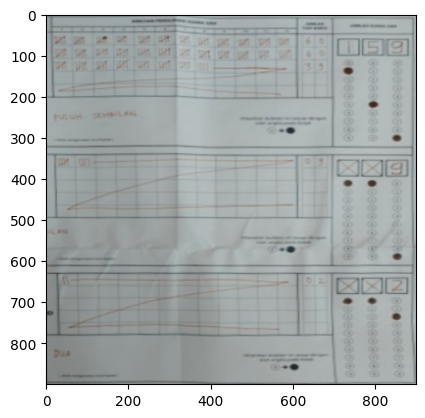

In [16]:
plt.imshow(images_data[0])


0: 640x640 3 blocks, 3 numbers, 12.6ms
Speed: 9.7ms preprocess, 12.6ms inference, 2462.5ms postprocess per image at shape (1, 3, 640, 640)
(50, 187, 3)
(51, 186, 3)
(51, 187, 3)
(206, 163, 3)
(201, 168, 3)
(202, 163, 3)


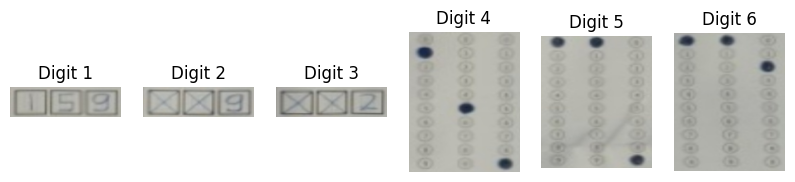

In [14]:
results = num_localize(images_data[0])[0]
detected_objects = results.boxes.xyxy

# Extract bounding box coordinates
detected_digit_coordinates = []
for detection in detected_objects:
    x1, y1, x2, y2 = detection.tolist()
    detected_digit_coordinates.append((x1, y1, x2, y2))
    
cropped_digits = crop_digits(images_data[0], detected_digit_coordinates)

# Simpan gambar-gambar hasil crop
plt.figure(figsize=(10, 5))
for i, digit_image in enumerate(cropped_digits, 1):
    plt.subplot(1, len(cropped_digits), i)
    plt.imshow(cv2.cvtColor(digit_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Digit {i}')
    print(digit_image.shape)
plt.show()

(50, 187, 3)
(51, 186, 3)
(51, 187, 3)


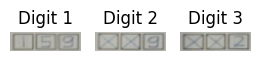

In [12]:
number_crop = []
for cropped in cropped_digits:
    if cropped.shape[0] < 100:
        number_crop.append(cropped)

for i, digit_image in enumerate(number_crop, 1):
    plt.subplot(1, len(cropped_digits), i)
    plt.imshow(cv2.cvtColor(digit_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Digit {i}')
    print(digit_image.shape)
plt.show()

# Model Number Segmentation

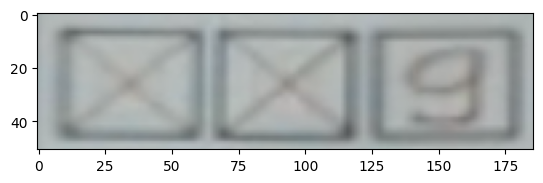

In [13]:
plt.imshow(number_crop[1])

In [14]:
def segmentation_number_image(image):
    results = num_segmentation(image)[0]
    detected_objects = results.boxes.xyxy

    # Extract bounding box coordinates
    detected_digit_coordinates = []
    for detection in detected_objects:
        x1, y1, x2, y2 = detection.tolist()
        detected_digit_coordinates.append((x1, y1, x2, y2))
        print((x1, y1, x2, y2))

    # Convert set back to a list
    detected_digit_coordinates = list(detected_digit_coordinates)
    sorted_digit_coordinates = sorted(detected_digit_coordinates, key=lambda x: x[0])

    # Remove tuples with x1 values that are very close
    filtered_digit_coordinates = []
    prev_x1 = None
    for tup in sorted_digit_coordinates:
        x1 = tup[0]
        if prev_x1 is not None and abs(x1 - prev_x1) < 20:
            # Skip this tuple if x1 is very close to the previous one
            continue
        filtered_digit_coordinates.append(tup)
        prev_x1 = x1

    cropped_digits = crop_digits(image, filtered_digit_coordinates)


    # Simpan gambar-gambar hasil crop
    plt.figure(figsize=(10, 5))
    for i, digit_image in enumerate(cropped_digits, 1):
        plt.subplot(1, len(cropped_digits), i)
        plt.imshow(cv2.cvtColor(digit_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Digit {i}')
        print(digit_image.shape)
    plt.show()

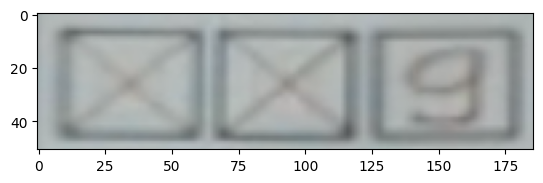

In [15]:
plt.imshow(number_crop[1])


0: 192x640 1 9, 87.2ms
Speed: 1.0ms preprocess, 87.2ms inference, 2.0ms postprocess per image at shape (1, 3, 192, 640)
(133.95162963867188, 11.087349891662598, 173.14694213867188, 42.960838317871094)
(31, 40, 3)


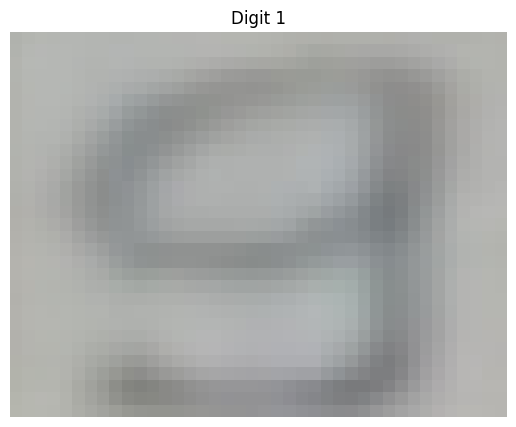

In [16]:
segmentation_number_image(number_crop[1])

# Make pipeline


0: 640x640 3 blocks, 3 numbers, 13.5ms
Speed: 3.6ms preprocess, 13.5ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 192x640 1 2, 1 3, 1 7, 83.8ms
Speed: 0.9ms preprocess, 83.8ms inference, 1.5ms postprocess per image at shape (1, 3, 192, 640)


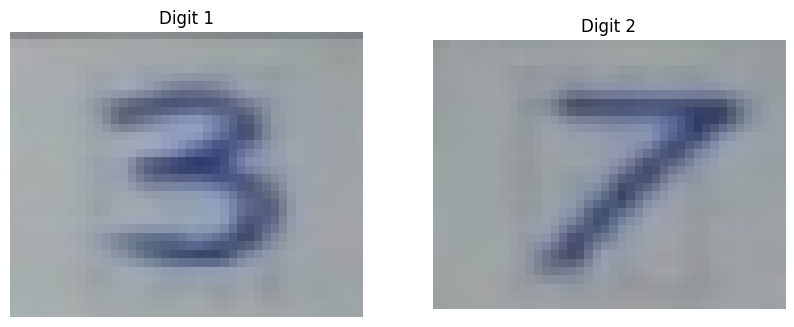

In [21]:
def number_localize(image):
    results = num_localize(image)[0]
    detected_objects = results.boxes.xyxy

    # Extract bounding box coordinates
    detected_digit_coordinates = []
    for detection in detected_objects:
        x1, y1, x2, y2 = detection.tolist()
        detected_digit_coordinates.append((x1, y1, x2, y2))
        
    detected_digit_coordinates = list(detected_digit_coordinates)
    sorted_digit_coordinates = sorted(detected_digit_coordinates, key=lambda x: x[1])

    cropped_digits = crop_digits(image, sorted_digit_coordinates)
    number_img = []
    for img in cropped_digits:
        if img.shape[0] < 60:
            number_img.append(img)
    
    return number_img

def segmentation_number_image(image):
    results = num_segmentation(image)[0]
    detected_objects = results.boxes.xyxy

    # Extract bounding box coordinates
    detected_digit_coordinates = []
    for detection in detected_objects:
        x1, y1, x2, y2 = detection.tolist()
        detected_digit_coordinates.append((x1, y1, x2, y2))

    # Convert set back to a list
    detected_digit_coordinates = list(detected_digit_coordinates)
    sorted_digit_coordinates = sorted(detected_digit_coordinates, key=lambda x: x[0])

    # Remove tuples with x1 values that are very close
    filtered_digit_coordinates = []
    prev_x1 = None
    for tup in sorted_digit_coordinates:
        x1 = tup[0]
        if prev_x1 is not None and abs(x1 - prev_x1) < 20:
            # Skip this tuple if x1 is very close to the previous one
            continue
        filtered_digit_coordinates.append(tup)
        prev_x1 = x1

    cropped_digits = crop_digits(image, filtered_digit_coordinates)
    
    return cropped_digits
    
number_image = number_localize(images_data[5])
number_segmented = segmentation_number_image(number_image[1])

plt.figure(figsize=(10, 5))
for i, digit_image in enumerate(number_segmented, 1):
    plt.subplot(1, len(number_segmented), i)
    plt.imshow(cv2.cvtColor(digit_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Digit {i}')
plt.show()

In [22]:
resize_digit = []
number_data = []
digit_data = []

for i in range(500):
    number_image = number_localize(images_data[i])
    number_data.append(number_image)
    
for i in range(500):
    for j in range(3):
        number_segmented = segmentation_number_image(number_data[i][j])
        digit_data.append(number_segmented)

for digit in digit_data:
    n_digit = len(digit)
    resize_per_digit = []
    for i in range(n_digit):
        resized_images = cv2.resize(digit[i], (227,227), 
                                        interpolation = cv2.INTER_LINEAR)
        resize_per_digit.append(resized_images)
    resize_digit.append(resize_per_digit)
    
cls()
print("Succesfully Preprocessed Image")

Succesfully Preprocessed Image


In [23]:
def plot_digit(index, data):
    plt.figure(figsize=(10, 5))
    for i, digit_image in enumerate(data[index], 1):
        plt.subplot(1, len(data[index]), i)
        plt.imshow(cv2.cvtColor(digit_image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f'Digit {i}')
    plt.show()

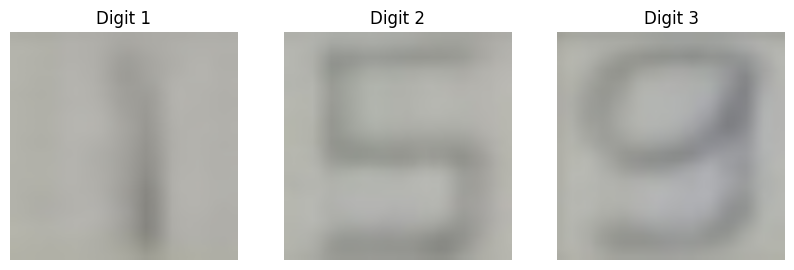

In [31]:
plot_digit(index=0, data=resize_digit)

In [26]:
label = pd.read_csv('/kaggle/input/gmmfst-penyisihan/data/data/label.csv')
label

,tps,suara_paslon_1,suara_paslon_2,suara_paslon_3
0,TPS_001,159,9,2
1,TPS_002,112,87,2
2,TPS_003,173,27,3
3,TPS_004,207,20,3
4,TPS_005,213,30,4
...,...,...,...,...
495,TPS_496,11,150,60
496,TPS_497,20,105,18
497,TPS_498,11,168,24
498,TPS_499,39,130,32


# Predict with Model

In [32]:
from tensorflow import keras
from tensorflow.keras import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.callbacks import EarlyStopping

In [33]:
import random

# Path ke folder grouped_images
folder_path = '/kaggle/input/gmmfst-penyisihan/tf number classification/dataset/grouped_images'

# Inisialisasi list untuk menyimpan gambar dan label
X = []
y = []

# Iterasi melalui setiap subfolder dalam grouped_images
for class_name in os.listdir(folder_path):
    class_folder = os.path.join(folder_path, class_name)
    class_label = int(class_name)  # Mengonversi nama subfolder menjadi label kelas
    
    # Iterasi melalui setiap file gambar dalam subfolder
    for image_file in os.listdir(class_folder):
        image_path = os.path.join(class_folder, image_file)
        
        # Baca gambar menggunakan OpenCV
        image = cv2.imread(image_path)
        
        # Tambahkan gambar dan label ke dalam list
        X.append(image)
        y.append(class_label)

# Konversi list menjadi array numpy
X = np.array(X)
y = np.array(y)

# Randomize the indices
indices = list(range(len(X)))
random.shuffle(indices)

# Use the randomized indices to shuffle X and y
X = X[indices]
y = y[indices]

# Cetak ukuran X dan y
print("Shape of X:", X.shape)
print("Shape of y:", y.shape)

Shape of X: (1059, 30, 30, 3)
Shape of y: (1059,)


In [34]:
class AlexNet(Sequential):
    def __init__(self, input_shape, num_classes):
        super().__init__()

        self.add(Conv2D(96, kernel_size = (11,11), strides = 4,
                        padding = 'valid', activation = 'relu',
                        input_shape=input_shape,
                        kernel_initializer = 'he_normal'))
        self.add(MaxPooling2D(pool_size = (3,3), strides=(2,2),
                              padding = 'valid'))
        
        self.add(Conv2D(256, kernel_size = (5,5), strides = 1,
                        padding = 'same', activation='relu',
                        kernel_initializer = 'he_normal'))
        self.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),
                              padding = 'valid'))
        
        self.add(Conv2D(384, kernel_size = (3,3), strides = 1,
                        padding = 'same', activation='relu',
                        kernel_initializer = 'he_normal'))
        
        self.add(Conv2D(384, kernel_size = (3,3), strides = 1,
                        padding = 'same', activation='relu',
                        kernel_initializer = 'he_normal'))
        
        self.add(Conv2D(256, kernel_size = (3,3), strides = 1,
                        padding = 'same', activation='relu',
                        kernel_initializer = 'he_normal'))
        
        self.add(MaxPooling2D(pool_size=(3,3), strides=(2,2),
                              padding = 'valid'))
        
        self.add(Flatten())
        
        self.add(Dropout(rate=0.5))
        self.add(Dense(4096, activation='relu'))
        self.add(Dropout(rate=0.5))
        self.add(Dense(4096, activation='relu'))

        self.add(Dense(num_classes, activation='softmax'))

In [35]:
early_stopping = EarlyStopping(min_delta = 0.001,patience = 20,restore_best_weights = True,verbose = 0)
model = AlexNet((227,227,3), num_classes = 10)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'],
              run_eagerly=True)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "alex_net"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 55, 55, 96)     │        34,944 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 27, 27, 96)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 27, 27, 256)    │       614,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 13, 13, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 13, 13, 384)    │       885,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 13, 13, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 13, 13, 256)    │       884,992 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4096)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    16,781,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │        40,970 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,322,314 (222.48 MB)

 Trainable params: 58,322,314 (222.48 MB)

 Non-trainable params: 0 (0.00 B)

In [27]:
from skimage import transform

def resize_images(images, img_size):
    resized_images = []

    for i in tqdm(range(0, len(images))):
        #img = cv2.cvtColor(images[i], cv2.COLOR_GRAY2RGB)
        img = images[i]
        resized_images.append(transform.resize(img, (img_size, img_size)).astype('float32'))

    return np.array(resized_images, dtype='float32')

In [28]:
X_resize = resize_images(X, 227)
X_resize.shape

100%|██████████| 1059/1059 [00:11<00:00, 90.92it/s]


(1059, 227, 227, 3)

In [29]:
X_train = X_resize[:900]
X_test = X_resize[900:]

y_train = y[:900]
y_test = y[900:]


print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(900, 227, 227, 3) (159, 227, 227, 3)
(900,) (159,)


In [43]:
X_train.shape

(900, 227, 227, 3)

In [130]:
history = model.fit(X_resize,y, batch_size = 256, epochs = 100,
          callbacks = [early_stopping])

Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 5s 996ms/step - accuracy: 0.9862 - loss: 0.0528
Epoch 2/100


/opt/conda/lib/python3.10/site-packages/keras/src/callbacks/early_stopping.py:156: UserWarning: Early stopping conditioned on metric `val_loss` which is not available. Available metrics are: accuracy,loss
  current = self.get_monitor_value(logs)


5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 0.9874 - loss: 0.0307
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - accuracy: 0.9943 - loss: 0.0274
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - accuracy: 0.9879 - loss: 0.0283
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 369ms/step - accuracy: 0.9953 - loss: 0.0170
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 376ms/step - accuracy: 0.9923 - loss: 0.0286
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 319ms/step - accuracy: 0.9923 - loss: 0.0256
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 308ms/step - accuracy: 0.9921 - loss: 0.0283
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 0.9791 - loss: 0.0605
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 306ms/step - accuracy: 0.9738 - loss: 0.0807
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 305ms/step - accuracy: 0.9858 - loss: 0.0548
Epoch 12/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 304ms/step - accuracy: 0.9832 - loss: 0.0491
Epoch 13/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 2s 303ms/step - accuracy: 0.9945 - l

In [131]:
prediction_prob = model.predict(np.array(resize_digit[0]))
prediction_class = np.argmax(prediction_prob,axis=1)
# Combine the digits into a single number
combined_number = int("".join(map(str, prediction_class)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


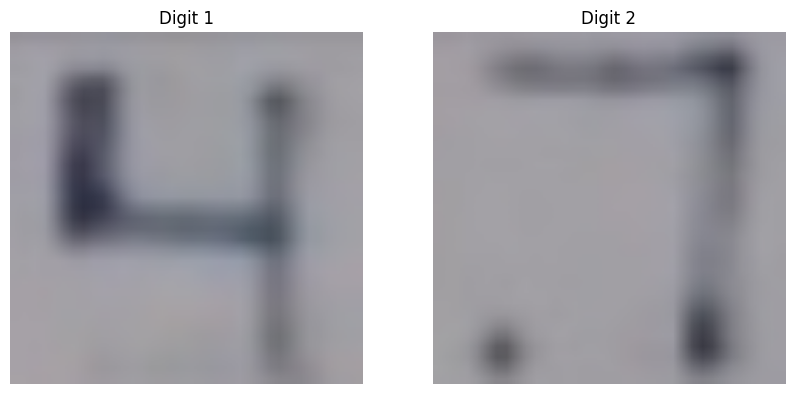

Predicted : 77


In [133]:
plt.figure(figsize=(10, 5))
for i, digit_image in enumerate(resize_digit[63], 1):
    plt.subplot(1, len(resize_digit[63]), i)
    plt.imshow(cv2.cvtColor(digit_image, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f'Digit {i}')
plt.show()
print(f'Predicted : {combined_number}')

In [134]:
paslon1 = []
paslon2 = []
paslon3 = []

for i in range(500):
    print(f'Index : {i}, Index * 3 : {i*3}')
    if len(resize_digit[i*3]) != 0:
        prediction_prob = model.predict(np.array(resize_digit[i*3]))
        prediction_class = np.argmax(prediction_prob,axis=1)
        combined_number = int("".join(map(str, prediction_class)))
        paslon1.append(combined_number)
    else:
        paslon1.append(0)
        
cls()
print('Done Predict')

Index : 0, Index * 3 : 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Index : 1, Index * 3 : 3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
Index : 2, Index * 3 : 6
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Index : 3, Index * 3 : 9
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Index : 4, Index * 3 : 12
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
Index : 5, Index * 3 : 15
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Index : 6, Index * 3 : 18
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Index : 7, Index * 3 : 21
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Index : 8, Index * 3 : 24
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Index : 9, Index * 3 : 27
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Index : 10, Index * 3 : 30
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Index : 11, Index * 3 : 33
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Index : 12, Index * 3 : 36
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
Index : 13, Index * 3 : 39
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
Index : 14, Index * 3 : 42
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Index : 15, Index * 3 : 45
1/1 ━━━━━━━━

IndexError: list index out of range

# Predict Test

In [111]:
folder_path = '/kaggle/input/gmmfst-penyisihan/data/data/Test'
file_list = os.listdir(folder_path)

# Remove the file extension and split the filename by '_'
file_parts = [file.split('_') for file in file_list]

# Filter out files that don't have the expected format
valid_files = [file for file in file_parts if len(file) == 2 and file[1].endswith('.jpg')]

# Sort the files based on the numeric part of the filename
sorted_files = sorted(valid_files, key=lambda x: int(x[1].split('.')[0]))

# Reconstruct the sorted filenames
sorted_file_list = ['_'.join(parts) for parts in sorted_files]

print(sorted_file_list)

['TPS_501.jpg', 'TPS_502.jpg', 'TPS_503.jpg', 'TPS_504.jpg', 'TPS_505.jpg', 'TPS_506.jpg', 'TPS_507.jpg', 'TPS_508.jpg', 'TPS_509.jpg', 'TPS_510.jpg', 'TPS_511.jpg', 'TPS_512.jpg', 'TPS_513.jpg', 'TPS_514.jpg', 'TPS_515.jpg', 'TPS_516.jpg', 'TPS_517.jpg', 'TPS_518.jpg', 'TPS_519.jpg', 'TPS_520.jpg', 'TPS_521.jpg', 'TPS_522.jpg', 'TPS_523.jpg', 'TPS_524.jpg', 'TPS_525.jpg', 'TPS_526.jpg', 'TPS_527.jpg', 'TPS_528.jpg', 'TPS_529.jpg', 'TPS_530.jpg', 'TPS_531.jpg', 'TPS_532.jpg', 'TPS_533.jpg', 'TPS_534.jpg', 'TPS_535.jpg', 'TPS_536.jpg', 'TPS_537.jpg', 'TPS_538.jpg', 'TPS_539.jpg', 'TPS_540.jpg', 'TPS_541.jpg', 'TPS_542.jpg', 'TPS_543.jpg', 'TPS_544.jpg', 'TPS_545.jpg', 'TPS_546.jpg', 'TPS_547.jpg', 'TPS_548.jpg', 'TPS_549.jpg', 'TPS_550.jpg', 'TPS_551.jpg', 'TPS_552.jpg', 'TPS_553.jpg', 'TPS_554.jpg', 'TPS_555.jpg', 'TPS_556.jpg', 'TPS_557.jpg', 'TPS_558.jpg', 'TPS_559.jpg', 'TPS_560.jpg', 'TPS_561.jpg', 'TPS_562.jpg', 'TPS_563.jpg', 'TPS_564.jpg', 'TPS_565.jpg', 'TPS_566.jpg', 'TPS_567.

In [112]:
folder_path = '/kaggle/input/gmmfst-penyisihan/data/data/Test'
images_test = load_images_from_folder(folder_path, (900,900))
print("Number of images loaded:", len(images_test))

Number of images loaded: 200


In [114]:
resize_digit = []
number_data = []
digit_data = []

for i in range(len(images_test)):
    number_image = number_localize(images_test[i])
    number_data.append(number_image)
    
for i in range(len(images_test)):
    for j in range(3):
        number_segmented = segmentation_number_image(number_data[i][j])
        digit_data.append(number_segmented)

for digit in digit_data:
    n_digit = len(digit)
    resize_per_digit = []
    for i in range(n_digit):
        resized_images = cv2.resize(digit[i], (227,227), 
                                        interpolation = cv2.INTER_LINEAR)
        resize_per_digit.append(resized_images)
    resize_digit.append(resize_per_digit)
    
cls()
print("Succesfully Preprocessed Image")

Succesfully Preprocessed Image


In [135]:
paslon1 = []
paslon2 = []
paslon3 = []

for i in range(len(images_test)):
    print(f'Index : {i}, Index * 3 : {i*3}')
    if len(resize_digit[i*3]) != 0:
        prediction_prob = model.predict(np.array(resize_digit[i*3]))
        prediction_class = np.argmax(prediction_prob,axis=1)
        combined_number = int("".join(map(str, prediction_class)))
        paslon1.append(combined_number)
    else:
        paslon1.append(0)
        
for i in range(len(images_test)):
    print(f'Index : {i}, Index * 3 : {(i*3)+1}')
    if len(resize_digit[(i*3)+1]) != 0:
        prediction_prob = model.predict(np.array(resize_digit[(i*3)+1]))
        prediction_class = np.argmax(prediction_prob,axis=1)
        combined_number = int("".join(map(str, prediction_class)))
        paslon2.append(combined_number)
    else:
        paslon2.append(0)
        
for i in range(len(images_test)):
    print(f'Index : {i}, Index * 3 : {(i*3)+2}')
    if len(resize_digit[(i*3)+2]) != 0:
        prediction_prob = model.predict(np.array(resize_digit[(i*3)+2]))
        prediction_class = np.argmax(prediction_prob,axis=1)
        combined_number = int("".join(map(str, prediction_class)))
        paslon3.append(combined_number)
    else:
        paslon3.append(0)
        
cls()
print('Done Predict')

Done Predict


In [136]:
test = pd.DataFrame(
{
    'suara_paslon_1' : paslon1,
    'suara_paslon_2' : paslon2,
    'suara_paslon_3' : paslon3
})

test

,suara_paslon_1,suara_paslon_2,suara_paslon_3
0,77,141,18
1,125,98,10
2,41,165,24
3,21,153,41
4,69,770,74
...,...,...,...
195,1,91,6
196,64,158,9
197,0,14,38
198,6,591,0


In [137]:
proporsi_paslon2 = (test['suara_paslon_2'] / (test['suara_paslon_1']+test['suara_paslon_2']+test['suara_paslon_3'])) * 100
proporsi_paslon2

0      59.745763
1      42.060086
2      71.739130
3      71.162791
4      84.337349
         ...    
195    92.857143
196    68.398268
197    26.923077
198    98.994975
199    98.854357
Length: 200, dtype: float64

In [139]:
submission = pd.read_csv('/kaggle/input/gmmfst-penyisihan/data/data/sample_submission.csv')
submission['Persentase Suara Sah Paslon 2'] = np.round(proporsi_paslon2,4)
submission.to_csv('2n using AlexNet.csv', index=False)